In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
#from metpy.io import get_test_data

import sys, os
import requests
import pyart

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#%matplotlib notebook

plt.style.use('default')


#import dask
#from dask.distributed import Client, progress, wait
#dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
#client = Client()
#client

#dask.config.set(scheduler='threads', num_workers=2)

from dask.distributed import Client
import dask

# Dashboard config for JupyterHub (optional)
dask.config.config.get('distributed').get('dashboard').update({
    'link': '{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'
})

# Start Dask client with controlled resources
client = Client(n_workers=4, threads_per_worker=2, memory_limit='5GB') # This will use 4*2=8 CPU threads
#client



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2025-09-22 11:11:02,015 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:40883' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('gt-bb13621f88d1664587fbbf7714f97107', 4, 2, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 12, 3, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 2, 0, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 17, 6, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 20, 1, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 35, 4, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 40, 2, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 7, 6, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 12, 5, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 3, 0, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 43, 3, 0), ('getitem-63e57db27b4ebbdfa9a578bb2cf0c896', 8, 5, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 0, 0, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 35, 6, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 38, 6, 0), ('gt-bb13621f88d1664587fbbf7714f97107', 28, 3,

In [2]:
import numpy as np
import warnings

np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:

file_path='/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/sull_ds'
ds_4sip = xr.open_mfdataset(f'{file_path}/4sip/dcmex_2mom/NWP_*.nc', chunks={'time': 4, 'height': 10},parallel=True)
ds_nosip = xr.open_mfdataset(f'{file_path}/nosip/dcmex_2mom/NWP_*.nc', chunks={'time': 4, 'height': 10},parallel=True)




/home/b/b382718/own_env/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'earthkit' loading failed:
unsupported operand type(s) for |: 'type' and 'types.GenericAlias'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/b/b382718/own_env/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'earthkit' loading failed:
unsupported operand type(s) for |: 'type' and 'types.GenericAlias'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/b/b382718/own_env/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'earthkit' loading failed:
unsupported operand type(s) for |: 'type' and 'types.GenericAlias'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/b/b382718/own_env/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'earthkit' loading failed:
unsupported operand type(s) for |: 'type' and

In [4]:

grid_dcmex = xr.open_dataset(f'{file_path}/4sip/dcmex_2mom/domain4_DOM04.nc');

clon_deg = np.degrees(grid_dcmex.clon)
clat_deg = np.degrees(grid_dcmex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-107., 34.])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.5
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

window_cell = (
    (grid_dcmex.clat >= np.deg2rad(bottom_bound))
    & (grid_dcmex.clat <= np.deg2rad(top_bound))
    & (grid_dcmex.clon >= np.deg2rad(left_bound))
    & (grid_dcmex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_dcmex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_dcmex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_dcmex = reindex_grid(grid_dcmex, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)
mask_cells = mask


-109.03369797063944
-104.96560387399306
32.96608133463784
37.035429759321914
-107.5
-106.5
34.5
33.5
window_vertex_indices :: [ 3601  3603  3610 ... 31347 31348 31349]
window_edge_indices :: [11226 11227 11228 ... 91282 91283 91284]


In [5]:

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['twc_gperm3'] = (ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl
ds_nosip['inp_perl'] = (ds_nosip.d_qni_het.diff('time'))*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['twc_gperm3'] = (ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl
ds_4sip['inp_perl'] = (ds_4sip.d_qni_het.diff('time'))*ds_4sip.rho*1.e-3 # perkg to perl
ds_4sip['inc_sip_perl'] = (ds_4sip.dqni_sec.diff('time'))*ds_4sip.rho*1.e-3 # perkg to perl


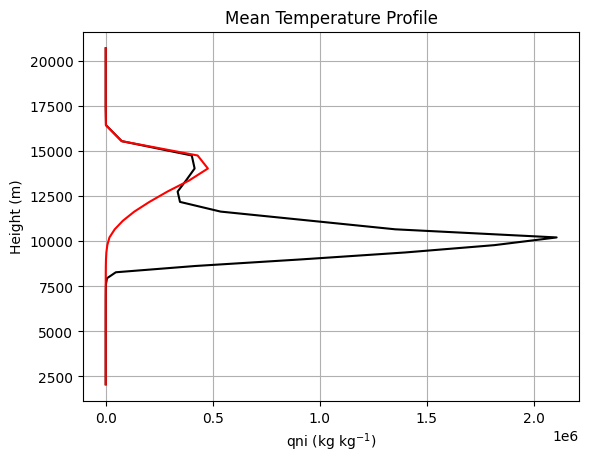

In [6]:
import matplotlib.pyplot as plt

# Compute the mean over time and ncells for both variables
qni_mean_4sip = ds_4sip.qni.mean(dim=('time', 'ncells'))
z_mean_4sip = ds_4sip.z_mc.mean(dim=('time', 'ncells'))

qni_mean_nosip = ds_nosip.qni.mean(dim=('time', 'ncells'))
z_mean_nosip = ds_nosip.z_mc.mean(dim=('time', 'ncells'))

# Now plot temperature (x-axis) vs. height (y-axis)
plt.style.use('default')
plt.plot(qni_mean_4sip, z_mean_4sip, 'k-')
plt.plot(qni_mean_nosip, z_mean_nosip, 'r-')
plt.xlabel('qni (kg kg$^{-1}$)')
plt.ylabel('Height (m)')
plt.title('Mean Temperature Profile')
plt.grid(True)
plt.show()


In [7]:

mean_ht_nosip = 1.e-3*ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

variables = [mean_tempc_nosip, mean_tempc_4sip]
numpy_variables = [var.values for var in variables]

mean_tempc_nosip = numpy_variables[0]
mean_tempc_4sip = numpy_variables[1]

variables = [mean_ht_nosip, mean_ht_4sip]
numpy_variables = [var.values for var in variables]

mean_ht_nosip = numpy_variables[0]
mean_ht_4sip = numpy_variables[1]


In [8]:

mask = (ds_4sip.tempc > -0.2) & (ds_4sip.tempc < 0.)
mean_freez_lev_4sip = 1.e-3*(ds_4sip.z_mc.where(mask)).mean(dim=('height','ncells'))
mask = (ds_4sip.tempc > -38.5) & (ds_4sip.tempc < -37.5)
mean_hom_lev_4sip = 1.e-3*(ds_4sip.z_mc.where(mask)).mean(dim=('height','ncells'))

mask = (ds_nosip.tempc > -0.2) & (ds_nosip.tempc < 0.)
mean_freez_lev_nosip = 1.e-3*(ds_nosip.z_mc.where(mask)).mean(dim=('height','ncells'))
mask = (ds_nosip.tempc > -38.5) & (ds_nosip.tempc < -37.5)
mean_hom_lev_nosip = 1.e-3*(ds_nosip.z_mc.where(mask)).mean(dim=('height','ncells'))


In [9]:

def signed_log(x, scale=0.08):
    return np.sign(x) * np.log1p(np.abs(x) / scale)
    

## Quality control

In [57]:
print(ds_4sip.inp_perl.min().values, ds_4sip.inp_perl.max().values)
print(ds_4sip.inc_perl.min().values, ds_4sip.inc_perl.max().values)
print(ds_4sip.w_vel.min().values, ds_4sip.w_vel.max().values)
print(ds_4sip.qc.min().values, ds_4sip.qc.max().values)
print(ds_4sip.tqi.min().values, ds_4sip.tqi.max().values)


-1.6044151e-08 3931.8015
0.0 152260.31
-6.065864 30.060001
0.0 0.0059292554
0.0 0.018000266


In [6]:

valid_ranges = {
    'inp_perl': (1.e-6, 1.e4), 
    'inc_perl': (1.e-6, 1.e6), 
    'inc_sip_perl': (1.e-6, 1.e6), 
    'ief': (1.e0, 1.e9),
    'w_vel': (-10., 40.),
    'tempc': (-40., 0.),
    'qc': (1.e-6, 1.e-1),       
    'tqi': (1.e-6, 1.e-1)}

ds_copy = ds_4sip[['tempc', 'w_vel', 'qc', 'tqi', 'inp_perl', 'inc_perl', 'inc_sip_perl']] 
ds_copy['ief'] = ds_copy.inc_perl/ds_copy.inp_perl

# Apply quality control by filtering out-of-range values
for var, (vmin, vmax) in valid_ranges.items():
    ds_copy[var] = ds_copy[var].where((ds_copy[var] >= vmin) & (ds_copy[var] <= vmax))

mask = (ds_copy['inc_sip_perl'] > ds_copy['inp_perl']).compute()
ds_filt = ds_copy.where(mask, drop=True)


ds_qc = ds_filt.chunk({'time': -1})

# Remove extreme outliers based on percentiles
for var in ['inp_perl', 'inc_perl', 'inc_sip_perl', 'ief', 'qc', 'tqi', 'tempc', 'w_vel']:
    upper = ds_qc[var].quantile(0.90, dim='time').values
    ds_qc = ds_qc.where(ds_qc[var] <= upper)



2025-09-22 11:11:02,014 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40883
Traceback (most recent call last):
  File "/home/b/b382718/own_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/b/b382718/own_env/lib/python3.9/site-packages/distributed/worker.py", line 2056, in gather_dep
    response = await get_data_from_worker(
  File "/home/b/b382718/own_env/lib/python3.9/site-packages/distributed/worker.py", line 2866, in get_data_from_worker
    response = await send_recv(
  File "/home/b/b382718/own_env/lib/python3.9/site-packages/distributed/core.py", line 1013, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/b/b382718/own_env/lib/python3.9/sit

In [15]:
import numpy as np
import xarray as xr
import pandas as pd

# Define bins for each variable (choose appropriate resolution)
temp_bins = np.arange(-40, 2, 0.3)       # e.g., every 0.3 °C from -40 to 0
w_vel_bins = np.arange(-10, 45, 0.3)     # e.g., every 5 m/s
qc_bins = np.linspace(1.e-6, 1.e-1, 30)     # 10 bins from 0 to 0.01
tqi_bins = np.linspace(1.e-6, 1.e-1, 30)    # 10 bins from 0 to 0.02

# Digitize each variable onto bin indices
temp_idx = np.digitize(ds_qc['tempc'].values.flatten(), temp_bins) - 1
w_vel_idx = np.digitize(ds_qc['w_vel'].values.flatten(), w_vel_bins) - 1
qc_idx = np.digitize(ds_qc['qc'].values.flatten(), qc_bins) - 1
tqi_idx = np.digitize(ds_qc['tqi'].values.flatten(), tqi_bins) - 1

ief_vals = ds_qc['ief'].values.flatten()

# Filter for valid bin indices inside range
valid_mask = (
    (temp_idx >= 0) & (temp_idx < len(temp_bins)-1) &
    (w_vel_idx >= 0) & (w_vel_idx < len(w_vel_bins)-1) &
    (qc_idx >= 0) & (qc_idx < len(qc_bins)-1) &
    (tqi_idx >= 0) & (tqi_idx < len(tqi_bins)-1) &
    ~np.isnan(ief_vals)
)

# Initialize lookup table and counts to compute average
lookup_shape = (len(temp_bins)-1, len(w_vel_bins)-1, len(qc_bins)-1, len(tqi_bins)-1)
lookup_sum = np.zeros(lookup_shape)
lookup_count = np.zeros(lookup_shape)

for ti, wi, qi_, tq, ief in zip(temp_idx[valid_mask], w_vel_idx[valid_mask], qc_idx[valid_mask], tqi_idx[valid_mask], ief_vals[valid_mask]):
    lookup_sum[ti, wi, qi_, tq] += ief
    lookup_count[ti, wi, qi_, tq] += 1

lookup_avg = np.divide(lookup_sum, lookup_count, out=np.zeros_like(lookup_sum), where=lookup_count>0)

# Convert back to xarray for easier visualization if desired
ief_lookup_table = xr.DataArray(
    data=lookup_avg,
    dims=['tempc_bin', 'w_vel_bin', 'qc_bin', 'tqi_bin'],
    coords={
        'tempc_bin': (temp_bins[:-1] + temp_bins[1:]) / 2,
        'w_vel_bin': (w_vel_bins[:-1] + w_vel_bins[1:]) / 2,
        'qc_bin': (qc_bins[:-1] + qc_bins[1:]) / 2,
        'tqi_bin': (tqi_bins[:-1] + tqi_bins[1:]) / 2,
    },
    name='IEF'
)


IEF = ief_lookup_table;

T_BIN, W_BIN, QC_BIN, TQI_BIN = xr.broadcast(
    IEF['tempc_bin'], 
    IEF['w_vel_bin'], 
    IEF['qc_bin'], 
    IEF['tqi_bin']
)


ds_ief = xr.Dataset({
    'IEF': IEF,
    'T_BIN': T_BIN,
    'W_BIN': W_BIN,
    'QC_BIN': QC_BIN,
    'TQI_BIN': TQI_BIN
})


output_path = '/work/bk1415/b382718/ICON_ANALYSIS/Ice_Enhancement_Factor/processed_qc_ief_dataset/ief_temp_w_qc_tqi_bins_dcmex.nc'

ds_ief.to_netcdf(output_path)



In [9]:
import numpy as np
import xarray as xr
import pandas as pd

# Define bins for each variable (choose appropriate resolution)
temp_bins = np.arange(-40, 2, 0.3)       # e.g., every 0.3 °C from -40 to 0
w_vel_bins = np.arange(-10, 45, 0.3)     # e.g., every 5 m/s
qc_bins = np.linspace(1.e-6, 1.e-1, 30)     # 10 bins from 0 to 0.01
tqi_bins = np.linspace(1.e-6, 1.e-1, 30)    # 10 bins from 0 to 0.02

# Digitize each variable onto bin indices
temp_idx = np.digitize(ds_qc['tempc'].values.flatten(), temp_bins) - 1
w_vel_idx = np.digitize(ds_qc['w_vel'].values.flatten(), w_vel_bins) - 1
#qc_idx = np.digitize(ds_qc['qc'].values.flatten(), qc_bins) - 1
#tqi_idx = np.digitize(ds_qc['tqi'].values.flatten(), tqi_bins) - 1

ief_vals = ds_qc['ief'].values.flatten()

# Filter for valid bin indices inside range
valid_mask = (
    (temp_idx >= 0) & (temp_idx < len(temp_bins)-1) &
    (w_vel_idx >= 0) & (w_vel_idx < len(w_vel_bins)-1) &
    ~np.isnan(ief_vals)
)

# Initialize lookup table and counts to compute average
lookup_shape = (len(temp_bins)-1, len(w_vel_bins)-1)
lookup_sum = np.zeros(lookup_shape)
lookup_count = np.zeros(lookup_shape)

for ti, wi, ief in zip(temp_idx[valid_mask], w_vel_idx[valid_mask], ief_vals[valid_mask]):
    lookup_sum[ti, wi] += ief
    lookup_count[ti, wi] += 1

lookup_avg = np.divide(lookup_sum, lookup_count, out=np.zeros_like(lookup_sum), where=lookup_count>0)

# Convert back to xarray for easier visualization if desired
ief_lookup_table = xr.DataArray(
    data=lookup_avg,
    dims=['tempc_bin', 'w_vel_bin'],
    coords={
        'tempc_bin': (temp_bins[:-1] + temp_bins[1:]) / 2,
        'w_vel_bin': (w_vel_bins[:-1] + w_vel_bins[1:]) / 2,
    },
    name='IEF'
)


IEF = ief_lookup_table;

T_BIN, W_BIN = xr.broadcast(
    IEF['tempc_bin'], 
    IEF['w_vel_bin']
)


ds_ief_tw = xr.Dataset({
    'IEF': IEF,
    'T_BIN': T_BIN,
    'W_BIN': W_BIN
})

output_path = '/work/bk1415/b382718/ICON_ANALYSIS/Ice_Enhancement_Factor/processed_qc_ief_dataset/ief_temp_w_bins_dcmex.nc'

ds_ief_tw.to_netcdf(output_path, mode='w')